In [1]:
%%capture
!pip install tensorflow pandas pyyaml h5py

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [4]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [5]:
def R2(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

In [6]:
test = dict(np.load("./data/data_single_test.npz"))

In [7]:
model = tf.keras.models.load_model("model_single.h5", custom_objects={"rmse": rmse, "R2": R2})

In [8]:
X_test, y_test = [test[i.name] for i in model.inputs], test["score"]
evaluate = model.predict(X_test).squeeze()
evaluate = pd.DataFrame([y_test, evaluate], index=["target", "predicted"]).T
evaluate['name'] = pd.read_csv("./data/single_muts_train.csv")["name"].apply(lambda x: x.split("_")[0])
evaluate.corr()

,target,predicted
target,1.000000,0.910432
predicted,0.910432,1.000000


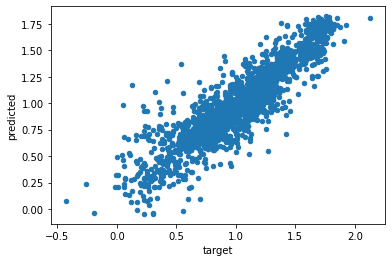

In [9]:
_ = evaluate.plot.scatter("target", "predicted")

In [10]:
evaluate["difference"] = np.sum(np.square(evaluate['target'] - evaluate['predicted']))
#evaluate["difference"] = evaluate['target'] - evaluate['predicted']

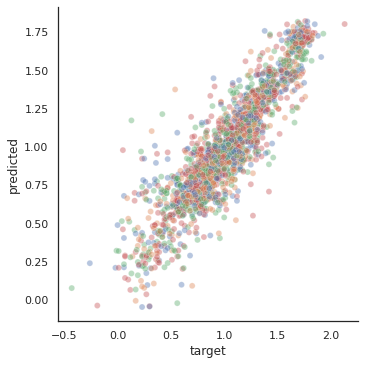

In [11]:
sns.set_theme(style="white")
_ = sns.relplot(x="target", y="predicted", hue='name',
                data=evaluate, legend = False,
                kind="scatter", 
                alpha=0.4)
plt.savefig('./data/performance.png', dpi=1200)

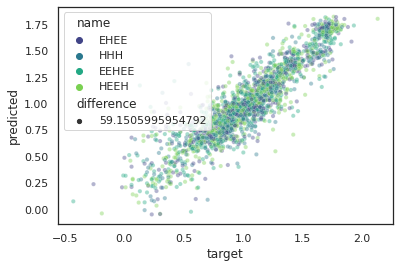

In [12]:
#sns.set_theme(style="white")
_ = sns.scatterplot(x="target", y="predicted", hue="name", 
                    size="difference" ,palette="viridis",
                    data=evaluate, alpha=0.4);
plt.savefig('./data/performance.png', dpi=1200)

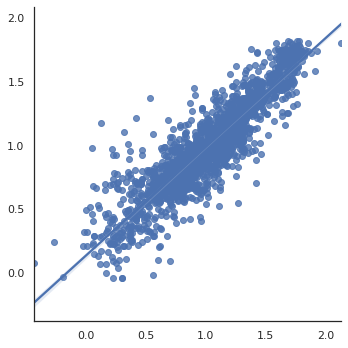

In [13]:
#sns.set_theme(style="white")
import scipy as sp
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['target'], data['predicted'])
    ax = plt.gca()
    return 'r={:.2f}, p={:.2g}'.format(r, p)
    

g = sns.lmplot(x="target", y="predicted",palette="viridis",
                    data=evaluate, legend=True);
g.map_dataframe(annotate)
plt.savefig('./data/performance.png', dpi=1200)

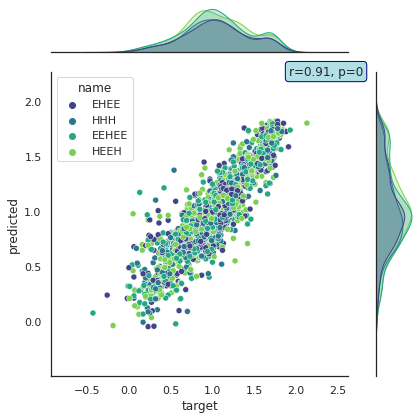

In [14]:
g = sns.jointplot(x="target", y="predicted", 
                  palette="viridis",hue="name",
                  data=evaluate);
g.ax_joint.annotate(annotate(evaluate), xy=(0.8, 1), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
plt.tight_layout()
plt.show()